In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from PIL import Image

In [3]:
# Define the path to the directory containing the folders
base_path = '../Preprocessed Dataset'

# List the folders in the directory
folders = ['IBM Plex Sans Arabic', 'Lemonada', 'Marhey', 'Scheherazade New']

# Create a dictionary to hold the labels for each folder
labels = {folder: i for i, folder in enumerate(folders)}

# Prepare a list to store the image data and labels
data = []

# Loop through each folder and each image within the folder
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpeg'):  # Correctly specify file type in comments and check
            image_path = os.path.join(folder_path, filename)
            try:
                # Load the image and convert to grayscale if not already
                with Image.open(image_path) as img:
                    if img.mode != 'L':
                        img = img.convert('L')
                    # Convert image data to array and binarize
                    image_data = np.array(img)
                    image_data = (image_data > 127).astype(np.uint8)  # Use uint8 for binary data
                    # Append the image data and label to the list
                    data.append((image_data, labels[folder]))

            except Exception as e:
                print(f"Failed to process {image_path}: {e}")

# Check what's in the data list
print(f"Total images loaded: {len(data)}")

Total images loaded: 3997


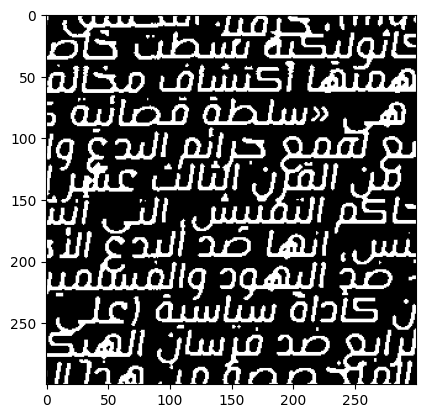

In [4]:
test_image = data[1013][0]
plt.imshow(test_image, cmap='gray')

In [5]:
def build_gabor_filters(orientations, frequencies, sigmas):
    filters = []
    for theta in orientations:
        for frequency, sigma in zip(frequencies, sigmas):
            lamda = 1 / frequency  # Wavelength
            gamma = 0.5  # Spatial aspect ratio

            # Adjust the kernel size based on the new sigma
            kernel_size = int(8 * sigma) if int(8 * sigma) % 2 == 1 else int(8 * sigma) + 1  # Ensure kernel size is odd
            zero_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
            neg_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lamda, gamma, -np.pi/2, ktype=cv2.CV_32F)
            filters.append([zero_kernel, neg_kernel])
    return filters


def apply_gabor_filters(image, filters):
    responses = np.zeros((len(filters), image.shape[0], image.shape[1]))
    for i, kernels in enumerate(filters):
        zero_kernel, neg_kernel = kernels[0], kernels[1]
        zero_filtered = cv2.filter2D(image, cv2.CV_8U, zero_kernel)  # Corrected data type for single-channel image
        neg_filtered = cv2.filter2D(image, cv2.CV_8U, neg_kernel)  # Corrected data type for single-channel image
        E = np.sqrt(zero_filtered ** 2 + neg_filtered ** 2)
        responses[i] = E
    return responses

In [6]:
# Define parameters
orientations = [k * np.pi / 32 for k in range(1, 32)]
frequencies = np.linspace(0.1, 0.5, 10)
sigmas = np.linspace(0.5, 5, 10)

# Generate and apply Gabor filters
gabor_filters = build_gabor_filters(orientations, frequencies, sigmas)
gabor_responses = apply_gabor_filters(test_image, gabor_filters)



In [7]:
gabor_responses.shape

(310, 300, 300)

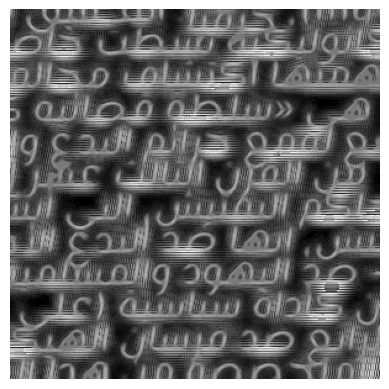

In [8]:
max_image = np.max(gabor_responses, axis=0)
plt.imshow(max_image, cmap='gray')
plt.axis('off')
plt.show()

In [9]:
def extract_features(gabor_responses):
    features = [] 
    # compute max image (per pixel) across all orientations and frequencies
    for i, response in enumerate(gabor_responses):
        # Calculate the mean and standard deviation of the response
        features.append(np.mean(response))
        features.append(np.std(response))
    
    max_image = np.max(gabor_responses, axis=0)
    features.append(np.mean(max_image))
    features.append(np.std(max_image))  

    return np.array(features)

In [10]:
features = extract_features(gabor_responses)
features.shape

(622,)

In [11]:
from sklearn.model_selection import train_test_split
# Assuming 'data' is the list that contains all your images and their labels
# Separate data into two lists: features and labels
data, labels = zip(*data)

# Convert these lists to numpy arrays for compatibility with sklearn
data = np.array(data)
labels = np.array(labels)

# Split the data using sklearn's train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
data = 1
labels = 1

# Check the size of the training and test sets
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 3197
Test set size: 800


In [12]:
# extract features for all images in the training set
X_train_features = np.array([extract_features(apply_gabor_filters(image, gabor_filters)) for image in X_train])

In [13]:
X_test_features = np.array([extract_features(apply_gabor_filters(image, gabor_filters)) for image in X_test])

In [14]:
print(X_train_features.shape)
print(X_test_features.shape)

(3197, 622)
(800, 622)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "SVM": svm.SVC(kernel='linear'),
    "Decision Tree": DecisionTreeClassifier()
}

# Train and test each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train_features, y_train)
    
    # Predict on the training data
    y_train_pred = clf.predict(X_train_features)
    
    # Predict on the test data
    y_test_pred = clf.predict(X_test_features)
    
    # Calculate and print the accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{name} - Training accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")

c:\Users\Marwan\anaconda3\envs\ML_course\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Training accuracy: 0.96, Test accuracy: 0.96
LDA - Training accuracy: 0.99, Test accuracy: 0.98


c:\Users\Marwan\anaconda3\envs\ML_course\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA - Training accuracy: 1.00, Test accuracy: 0.97
SVM - Training accuracy: 0.97, Test accuracy: 0.96
Decision Tree - Training accuracy: 1.00, Test accuracy: 0.85


In [16]:
import pickle

def write_features_to_file(features, filename):
    with open(filename, 'wb') as f:
        pickle.dump(features, f)

# Use the function to write X_train_features to a .pkl file
write_features_to_file(X_train_features, 'train_features.pkl')
write_features_to_file(X_test_features, 'test_features.pkl')

In [17]:
def load_features_from_file(filename):
    with open(filename, 'rb') as f:
        features = pickle.load(f)
    return features

# Use the function to load features from a .pkl file
X_train_features_pkl = load_features_from_file('train_features.pkl')
X_test_features_pkl = load_features_from_file('test_features.pkl')

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "SVM": svm.SVC(kernel='linear'),    
    "Decision Tree": DecisionTreeClassifier()
}

# Train and test each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train_features, y_train)
    
    # Predict on the training data
    y_train_pred = clf.predict(X_train_features_pkl)
    
    # Predict on the test data
    y_test_pred = clf.predict(X_test_features_pkl)
    
    # Calculate and print the accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{name} - Training accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")

c:\Users\Marwan\anaconda3\envs\ML_course\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Training accuracy: 0.96, Test accuracy: 0.96
LDA - Training accuracy: 0.99, Test accuracy: 0.98


c:\Users\Marwan\anaconda3\envs\ML_course\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA - Training accuracy: 1.00, Test accuracy: 0.97
SVM - Training accuracy: 0.97, Test accuracy: 0.96
Decision Tree - Training accuracy: 1.00, Test accuracy: 0.84
